# Introduction

This notebook contains a Transformer model for performing lip-reading on video English speakers.

# 1: Import Data

In [1]:
"""
Mount Google Drive to import data.
"""

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
"""
Locate and unzip data in individual user's Google Drive.
"""

# !unzip /content/drive/MyDrive/Senior/Spring/EC523/FinalProject/ec523/data.zip
# !unzip /content/drive/MyDrive/School/Graduate/Classes/2024\ Spring/EC523\ Deep\ Learning/data.zip
!unzip /content/drive/MyDrive/data.zip


Archive:  /content/drive/MyDrive/School/Graduate/Classes/2024 Spring/EC523 Deep Learning/data.zip
   creating: data/
  inflating: data/.DS_Store          
   creating: data/annotations/
   creating: data/videos/
  inflating: data/annotations/.DS_Store  
   creating: data/annotations/s1/
  inflating: data/videos/prwq3s.mpg  
  inflating: data/videos/pbib8p.mpg  
  inflating: data/videos/lrae3s.mpg  
  inflating: data/videos/pgid6p.mpg  
  inflating: data/videos/pbao8n.mpg  
  inflating: data/videos/prbx3s.mpg  
  inflating: data/videos/lbbk6p.mpg  
  inflating: data/videos/bgwu6n.mpg  
  inflating: data/videos/sbig6p.mpg  
  inflating: data/videos/pgby5s.mpg  
  inflating: data/videos/bras8p.mpg  
  inflating: data/videos/sgiczp.mpg  
  inflating: data/videos/lrwl7a.mpg  
  inflating: data/videos/bbbz8n.mpg  
  inflating: data/videos/bram3s.mpg  
  inflating: data/videos/pwwk7a.mpg  
  inflating: data/videos/bbws8n.mpg  
  inflating: data/videos/brbtzn.mpg  
  inflating: data/videos/bww

# 2: Visualize Data

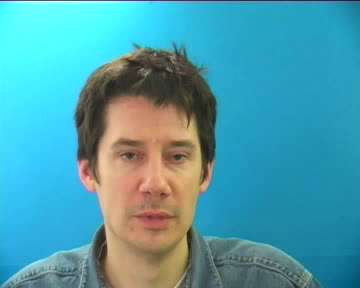

Sample Video: sgai8p.mpg
Corresponding Annotation: sgai8p.align
Annotation Content: 
 0 8500 sil
8500 15750 set
15750 20500 green
20500 21750 at
21750 25500 i
25500 31500 eight
31500 40000 please
40000 74500 sil



In [3]:
"""
Define data directories and load raw sample data to visualize.
"""

from google.colab.patches import cv2_imshow
import os
import cv2
from tensorflow.keras.preprocessing.text import Tokenizer

data_dir        = os.path.join('/content', 'data')
videos_dir      = os.path.join(str(data_dir), 's1')
annotations_dir = os.path.join(data_dir, 'alignments', 's1')
example_data    = os.path.join('/content', 'example_data')
!mkdir example_data


# Func to find corresponding annotation file for a video file
def find_annotation_file(video_file):
    base_name       = os.path.splitext(video_file)[0]
    annotation_file = base_name + '.align'

    return annotation_file


# Get data
sample_video       = os.listdir(videos_dir)[0]
example_video_path = os.path.join(videos_dir, sample_video)

sample_annotation  = find_annotation_file(sample_video)
annotation_path    = os.path.join(annotations_dir, sample_annotation)

with open(annotation_path, 'r') as annotation_file:
    annotation_content = annotation_file.read()

# Display frame from sample video
cap = cv2.VideoCapture(example_video_path)
ret, frame = cap.read()
cap.release()
cv2_imshow(frame)

# Print corresponding data
print("Sample Video:", sample_video)
print("Corresponding Annotation:", sample_annotation)
print("Annotation Content: \n", annotation_content)



# 3: Load Data


In [121]:
"""
Consolidated global parameters and model hyper-parameters.
"""

# Static LipNet params
words_per_clip  = 8
vocab_size      = 53
frames_per_clip = 75  # Generally 75 (few have slightly different frame counts)
video_cnt       = 1000

# Other Parameters
frame_width  = 80     # originally 224; 120?
frame_height = 40     # originally 224; 60?
vert_scale   = 1.3    # extend bound box up above mouth to include face; 2?
color        = False  # whether to convert to grayscale

# Model params
num_layers    = 2      # TODO: RE-IMPLEMENT
embedding_dim = 32    # Not below 32
num_heads     = 8      # 8 or above
feedfor_dim   = 32    # Not below 32
dropout_rate  = 0.1    # TODO: ?
learning_rate = 0.001  # 0.001 seems best

# Training data params
sample_size = 200  # 512 for now (max is 1000); use TPU
batch_size  = 32    # TODO: ?
epochs      = 10    # 5 usually sufficient to see pattern
train_ratio = 0.95  # % for training and validation; rest for testing

# Keywords/Tokens in LipNet dataset
words = ['a', 'again', 'at', 'b', 'bin', 'blue', 'by', 'c', 'd', 'e',
         'eight', 'f', 'five', 'four', 'g', 'green', 'h', 'i', 'in', 'j',
         'k', 'l', 'lay', 'm', 'n', 'nine', 'now', 'o', 'one', 'p',
         'place', 'please', 'q', 'r', 'red', 's', 'set', 'seven', 'sil', 'six',
         'soon', 'sp', 't', 'three', 'two', 'u', 'v', 'white', 'with', 'x',
         'y', 'z', 'zero']


In [122]:
"""
Tokenize annotations, define funcs to load data, and print the data dims.
"""

import math
import cv2
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Unique syllable tokens in LipNet dataset
tokenizer = Tokenizer()
tokenizer.fit_on_texts(words)


def load_video_frames(video_path, num_frames=frames_per_clip,
                      target_size=(frame_width, math.floor(frame_height*vert_scale)),
                      batch_size=batch_size):
    frames = []
    cap    = cv2.VideoCapture(video_path)
    count  = 0
    while True:
        ret, frame = cap.read()
        if not ret or count >= num_frames:
            break
        frame = cv2.resize(frame, target_size)
        frame = frame.astype(np.float32) / 255.0
        frames.append(frame)
        count += 1
    cap.release()
    while len(frames) < num_frames:
        frames.append(np.zeros_like(frames[0]))

    frames = np.array(frames)

    return frames


# Load and tokenize annotations
def load_annotation(annotation_file, max_length=8):
    with open(annotation_file, 'r') as file:
        annotations = file.readlines()

    # Filter out all annotation text other than keyword
    trimmed_annotations = []
    for annotation in annotations:
        trimmed_annotations.append(annotation.strip().split()[2])

    # Tokenize the words to sequences (lists) of letter tokens (and truncate)
    sequence   = [token[0] for token in tokenizer.texts_to_sequences(trimmed_annotations)]
    padded_seq = pad_sequences([sequence], maxlen=max_length, padding='post', truncating='post')[0]

    # print(annotation_file, '...')
    # print('raw annotations: ',    annotations)
    # print('trimmed annotations:', trimmed_annotations)
    # print('sequences:',           sequence)
    # print('padded_sequences: ',   padded_seq)

    return padded_seq


# Print sample frames data
sample_video_path = os.path.join(videos_dir, sample_video)  # sample video path
video_frames      = load_video_frames(sample_video_path)    # load video frames
print("Number of frames in the video:", len(video_frames))
print("Shape of each frame:", video_frames[0].shape)
# print("Video frames example: \n", video_frames[0])

# Print sample annotation data
max_length = 8  # 6 words and a 'sil' on either end...
annotation_sequences = load_annotation(annotation_path, max_length=max_length)
print("\nTotal number of tokens: ", len(words))  # 53
print("Preprocessed annotation sequences shape:", annotation_sequences.shape)
print("Annotation sequences example: \n", annotation_sequences)


Number of frames in the video: 75
Shape of each frame: (52, 80, 3)

Total number of tokens:  53
Preprocessed annotation sequences shape: (8,)
Annotation sequences example: 
 [39 37 16  3 18 11 32 39]


# 4: Pre-Process Data

In [123]:
"""
Define funcs to perform pre-processing on both video frames and annotations.
"""

import os
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.sequence import pad_sequences
import cv2


# Use Haar cascade for lip detection
# More reliable to track entire face then crop to lips...
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# lips_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')
# eyes_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')


def process_video_file(path: str, save_frames: bool = False):
    """
    TODO: Maybe use average background color (backdrop is cyan) to check accuracy; default to center if close to cyan...
    """

    # Load video
    cap = cv2.VideoCapture(path)  # e.g. /content/data/videos/bbaf2n.mpg

    tensors_list = []

    frame_count = 0
    while True:

        # Read frame from vid
        ret, raw = cap.read()
        if not ret or frame_count >= frames_per_clip:
            break

        # Convert to grey scale
        frame = raw
        if not color:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Face detection
        for x in reversed(range(5, 8)):  # lower conditions as needed to find best match
            face = face_cascade.detectMultiScale(frame, scaleFactor=1.1, minNeighbors=x,
                                                 minSize=(60,  30),
                                                 maxSize=(120, 60))
            if len(face) > 0:
                break
        if len(face) == 0:  # if still no match, use static vals
            # print(f'{frame_count}: default crop')
            face = [[50, 150, 200, 100]]

        (x, y, w, h) = face[0]
        # print(f'{frame_count:02d}', ': ', face[0])

        # Store normalized, grayscaled, and uniformly cropped
        frame = cv2.normalize(frame, frame, 0, 100, cv2.NORM_MINMAX)
        frame = frame[y+(h//2):y+h, x+(w//4):x+(3*w//4)]
        frame = cv2.resize(frame, (frame_width, frame_height))

        tensors_list.append(frame)

        if save_frames:

            # Save to file
            cv2.imwrite(os.path.join(example_data, f'frame_{frame_count:02d}.jpg'), frame)

            # Save some of the color images with the bounding box...
            if frame_count % 10 == 0:
                cv2.rectangle(raw, (x, math.floor(y/vert_scale)), (x+w, y+h), (0, 200, 0), 2)  # draws rectangle
                cv2.imwrite(os.path.join(example_data, f'frame_{frame_count:02d}_box.jpg'), raw)

        frame_count += 1

    cap.release()

    while len(tensors_list) < frames_per_clip:
        tensors_list.append(np.zeros_like(tensors_list[0]))

    # print(f"Finished processing video; {frame_count} frames saved in:", output_dir)
    # print(f'\nvideo_tensor ({type(video_tensor)}, {video_tensor.shape}): \n', video_tensor)

    return tensors_list


# Preprocess data (resize frames, tokenize annotations)
def preprocess_data(video_paths, annotation_paths, words_per_clip):
    video_cnt        = len(video_paths)
    annotation_cnt   = len(annotation_paths)
    video_dims       = (frames_per_clip, frame_height, frame_width)
    if color:
        video_dims   = (frames_per_clip, frame_height, frame_width, 3)
    annotation_dims  = (words_per_clip, )
    # print(video_dims)
    assert video_cnt == annotation_cnt

    video_frames = []
    for i, path in enumerate(video_paths):
        if i % 5 == 0:
            print(f'Video: {i} / {video_cnt}')
        frames = process_video_file(path)
        frames = np.array(frames[:frames_per_clip])
        # print(frames.shape)
        assert frames.shape == video_dims
        video_frames.append(frames)

    annotations = []
    for i, path in enumerate(annotation_paths):
        if i % 5 == 0:
            print(f'Annotation: {i} / {annotation_cnt}')
        annotation_set = np.array(load_annotation(path, words_per_clip))
        # print(annotation_set.shape)
        assert annotation_set.shape == annotation_dims
        annotations.append(annotation_set)

    print('Video_frames shape:\n', video_frames[3].shape)
    print('Annotation shape:  \n', annotations[3].shape)

    return np.array(video_frames), np.array(annotations)


# Generate example images
# Save example pre-processed frames to /content/example_data
# Every 10th frame will be the uncropped version with the Haar classifier bounding
result = np.array(process_video_file(example_video_path, True))  # Same example as above
print('Example pre-processed video tensor shape: ', result.shape)


Example pre-processed video tensor shape:  (75, 40, 80)


In [124]:
"""
Pre-process all of the data, storing it in arrays.
"""

import os
import random
import shutil

# List video files, then generate corresponding list of annotations
video_files      = [os.path.join(videos_dir, file) for file in os.listdir(videos_dir) if file.endswith('.mpg')]
annotation_files = [os.path.join(annotations_dir, os.path.basename(file).replace('.mpg', '.align')) for file in video_files]

# Extract pre-processed frames and annotations
all_video_frames, all_annotations = preprocess_data(video_files[:sample_size],
                                                    annotation_files[:sample_size],
                                                    words_per_clip)


Video: 0 / 200
Video: 5 / 200
Video: 10 / 200
Video: 15 / 200
Video: 20 / 200
Video: 25 / 200
Video: 30 / 200
Video: 35 / 200
Video: 40 / 200
Video: 45 / 200
Video: 50 / 200
Video: 55 / 200
Video: 60 / 200
Video: 65 / 200
Video: 70 / 200
Video: 75 / 200
Video: 80 / 200
Video: 85 / 200
Video: 90 / 200
Video: 95 / 200
Video: 100 / 200
Video: 105 / 200
Video: 110 / 200
Video: 115 / 200
Video: 120 / 200
Video: 125 / 200
Video: 130 / 200
Video: 135 / 200
Video: 140 / 200
Video: 145 / 200
Video: 150 / 200
Video: 155 / 200
Video: 160 / 200
Video: 165 / 200
Video: 170 / 200
Video: 175 / 200
Video: 180 / 200
Video: 185 / 200
Video: 190 / 200
Video: 195 / 200
Annotation: 0 / 200
Annotation: 5 / 200
Annotation: 10 / 200
Annotation: 15 / 200
Annotation: 20 / 200
Annotation: 25 / 200
Annotation: 30 / 200
Annotation: 35 / 200
Annotation: 40 / 200
Annotation: 45 / 200
Annotation: 50 / 200
Annotation: 55 / 200
Annotation: 60 / 200
Annotation: 65 / 200
Annotation: 70 / 200
Annotation: 75 / 200
Annotati

In [125]:
"""
Split data into training and test datasets and print the size/example of each.
TF handles the split of training and validation data...
"""

import random

# Training : Testing split
num_train = int(train_ratio * sample_size)

# Split data
vid_subset      = all_video_frames[:num_train]
ann_subset      = all_annotations[:num_train]

test_vid_subset = all_video_frames[num_train:]
test_ann_subset = all_annotations[num_train:]

# Shuffle data
indices = np.arange(vid_subset.shape[0])
np.random.shuffle(indices)
video_frames = vid_subset[indices]  # key input variable used throughout code
annotations  = ann_subset[indices]  # key label variable used throughout code

indices = np.arange(test_vid_subset.shape[0])
np.random.shuffle(indices)
test_video_frames = test_vid_subset[indices]
test_annotations  = test_ann_subset[indices]

# Print shapes and types and an example
print("Num frames in train data:",       len(video_frames),      type(video_frames))
print("Num annotations in train data:",  len(annotations),       type(annotations))

print("Num frames in test data:",        len(test_video_frames), type(test_video_frames))
print("Num annotations in test data:",   len(test_annotations),  type(test_annotations))

print("Example annotation: ", annotations[0])  # ensure shuffles each time


Num frames in train data: 190 <class 'numpy.ndarray'>
Num annotations in train data: 190 <class 'numpy.ndarray'>
Num frames in test data: 10 <class 'numpy.ndarray'>
Num annotations in test data: 10 <class 'numpy.ndarray'>
Example annotation:  [39 31  6  7 47 40 27 39]


# 5: Design Model

In [126]:
"""
Define the Transformer classes and func to create a model.
"""

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, MultiHeadAttention, Dense, Dropout, LayerNormalization, TimeDistributed, Input, Flatten, Reshape


# Encoder layer
class TransformerEncoder(layers.Layer):

    def __init__(self, embedding_dim=64, num_heads=8, feedfor_dim=64, drop_rate=0.1, **kwargs):
        super(TransformerEncoder, self).__init__()

        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(feedfor_dim, activation='relu'),
            layers.Dense(embedding_dim)
        ])

        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(drop_rate)
        self.dropout2 = layers.Dropout(drop_rate)

    def call(self, inputs, training):

        attn_output = self.mha(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)

        out1 = self.layer_norm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)

        return self.layer_norm2(out1 + ffn_output)


# Build and compile model
def build_sequential_model(words_per_clip=8, frames_per_clip=75, vocab_size=53,
        embedding_dim=64,
        num_heads=8,
        feedfor_dim=64,
        dropout_rate=0.1,
        learning_rate=0.0001,
        batch_size=16
    ):
    model = Sequential([
        # Input(shape=(frames_per_clip, math.floor(frame_width*frame_height*vert_scale*3))),
        Input(shape=(frames_per_clip, frame_width * frame_height * (3 if color else 1))),
        # Flatten(),
        Dense(embedding_dim, activation='relu'),
        Reshape((frames_per_clip, -1)),
        # Dropout(0.5),
        TransformerEncoder(embedding_dim=embedding_dim, num_heads=num_heads,
                           feedfor_dim=feedfor_dim, drop_rate=dropout_rate),
        Reshape((words_per_clip, -1)),
        TimeDistributed(Dense(vocab_size + 1, activation='softmax'))  # Generates word sequences
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])  # 'accuracy'?

    return model


# 6: Create Model

In [127]:
"""
Create model and print summary of architecture.
"""

transformer_model = build_sequential_model(
    words_per_clip  = words_per_clip,
    frames_per_clip = frames_per_clip,
    vocab_size      = vocab_size,
    embedding_dim   = embedding_dim,
    num_heads       = num_heads,
    feedfor_dim     = feedfor_dim,
    dropout_rate    = dropout_rate,
    learning_rate   = learning_rate,
    batch_size      = batch_size
)
transformer_model.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 75, 32)            102432    
                                                                 
 reshape_14 (Reshape)        (None, 75, 32)            0         
                                                                 
 transformer_encoder_7 (Tra  (None, 75, 32)            35808     
 nsformerEncoder)                                                
                                                                 
 reshape_15 (Reshape)        (None, 8, 300)            0         
                                                                 
 time_distributed_7 (TimeDi  (None, 8, 54)             16254     
 stributed)                                                      
                                                                 
Total params: 154494 (603.49 KB)
Trainable params: 15

# 7: Train/Test Model


In [128]:
"""
Load subset of the pre-processed data and print data shapes.
"""

video_array = video_frames[:len(video_frames)]
videos_flat = video_array.reshape((len(video_frames), frames_per_clip, -1))

# print('Shape of video frame: ', video_frames[0].shape)
print('Shape of flat videos: ', videos_flat.shape)
print('Shape of annotations: ', annotations.shape)

# print('Count of video frame: ', len(video_frames))
print('Count of flat videos: ', len1 := len(videos_flat))
print('Count of annotations: ', len2 := len(annotations))
assert len1 == len2


Shape of flat videos:  (190, 75, 3200)
Shape of annotations:  (190, 8)
Count of flat videos:  190
Count of annotations:  190


In [129]:
"""
Train and validate model and store history.
"""

history = transformer_model.fit(x                = videos_flat,
                                y                = annotations,
                                batch_size       = batch_size,
                                epochs           = epochs,
                                validation_split = 0.2)


Epoch 1/10
5/5 [==============================] - 3s 100ms/step - loss: 3.8727 - sparse_categorical_accuracy: 0.1653 - val_loss: 3.1193 - val_sparse_categorical_accuracy: 0.3388
Epoch 2/10
5/5 [==============================] - 0s 21ms/step - loss: 2.7611 - sparse_categorical_accuracy: 0.3618 - val_loss: 2.3843 - val_sparse_categorical_accuracy: 0.3882
Epoch 3/10
5/5 [==============================] - 0s 20ms/step - loss: 2.1976 - sparse_categorical_accuracy: 0.3931 - val_loss: 1.9859 - val_sparse_categorical_accuracy: 0.3914
Epoch 4/10
5/5 [==============================] - 0s 21ms/step - loss: 1.8342 - sparse_categorical_accuracy: 0.4030 - val_loss: 1.7458 - val_sparse_categorical_accuracy: 0.3618
Epoch 5/10
5/5 [==============================] - 0s 21ms/step - loss: 1.6555 - sparse_categorical_accuracy: 0.3931 - val_loss: 1.6130 - val_sparse_categorical_accuracy: 0.4178
Epoch 6/10
5/5 [==============================] - 0s 20ms/step - loss: 1.5569 - sparse_categorical_accuracy: 0.388

# 8: Plot Results

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])
{'loss': [3.8726654052734375, 2.7611441612243652, 2.1975972652435303, 1.8342387676239014, 1.6554641723632812, 1.5568853616714478, 1.5282610654830933, 1.4939459562301636, 1.4815927743911743, 1.4737402200698853], 'sparse_categorical_accuracy': [0.1652960479259491, 0.3618420958518982, 0.3930920958518982, 0.40296053886413574, 0.3930920958518982, 0.3881579041481018, 0.3947368562221527, 0.40707236528396606, 0.4128289520740509, 0.39638158679008484], 'val_loss': [3.119264602661133, 2.384326219558716, 1.985943078994751, 1.7458269596099854, 1.6130048036575317, 1.5653655529022217, 1.5320583581924438, 1.5155625343322754, 1.5030558109283447, 1.497300624847412], 'val_sparse_categorical_accuracy': [0.3388157784938812, 0.3881579041481018, 0.39144736528396606, 0.3618420958518982, 0.4177631437778473, 0.40460526943206787, 0.4177631437778473, 0.38486841320991516, 0.375, 0.39144736528396606]}


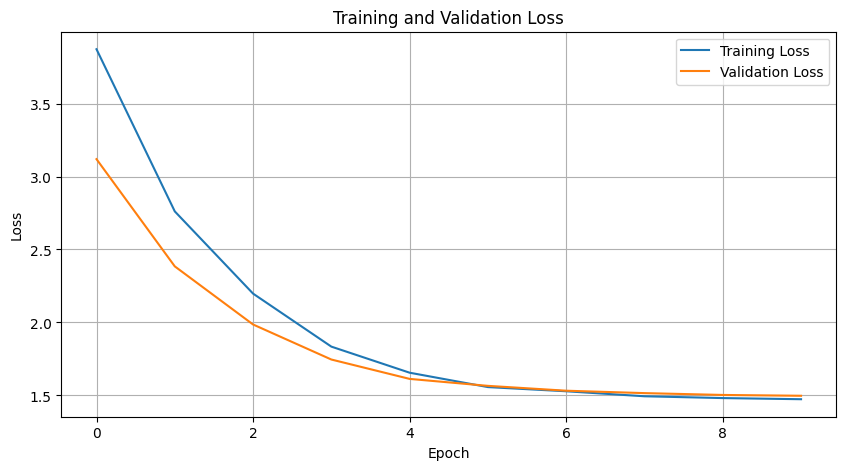

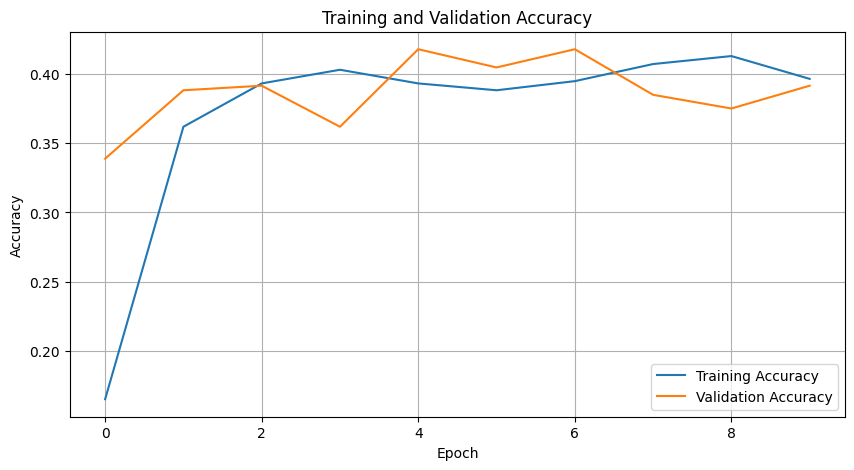

train loss:  3.8726654052734375
train loss:  2.7611441612243652
train loss:  2.1975972652435303
train loss:  1.8342387676239014
train loss:  1.6554641723632812
train loss:  1.5568853616714478
train loss:  1.5282610654830933
train loss:  1.4939459562301636
train loss:  1.4815927743911743
train loss:  1.4737402200698853
validation loss:  3.119264602661133
validation loss:  2.384326219558716
validation loss:  1.985943078994751
validation loss:  1.7458269596099854
validation loss:  1.6130048036575317
validation loss:  1.5653655529022217
validation loss:  1.5320583581924438
validation loss:  1.5155625343322754
validation loss:  1.5030558109283447
validation loss:  1.497300624847412
train accuracy:  0.1652960479259491
train accuracy:  0.3618420958518982
train accuracy:  0.3930920958518982
train accuracy:  0.40296053886413574
train accuracy:  0.3930920958518982
train accuracy:  0.3881579041481018
train accuracy:  0.3947368562221527
train accuracy:  0.40707236528396606
train accuracy:  0.41282

In [136]:
"""
Generate plots for the loss & accuracy for the training & validation datsets.
"""

import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss   = history.history['val_loss']
train_acc  = history.history['sparse_categorical_accuracy']
val_acc    = history.history['val_sparse_categorical_accuracy']

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss,   label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
print('\n')

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc,   label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Print actual values
for v in train_loss:
    print('train loss: ', v)
for v in val_loss:
    print('validation loss: ', v)
for v in train_acc:
    print('train accuracy: ', v)
for v in val_acc:
    print('validation accuracy: ', v)


# Best Plots

If a good plot is generated, paste copies here so we don't lose them...


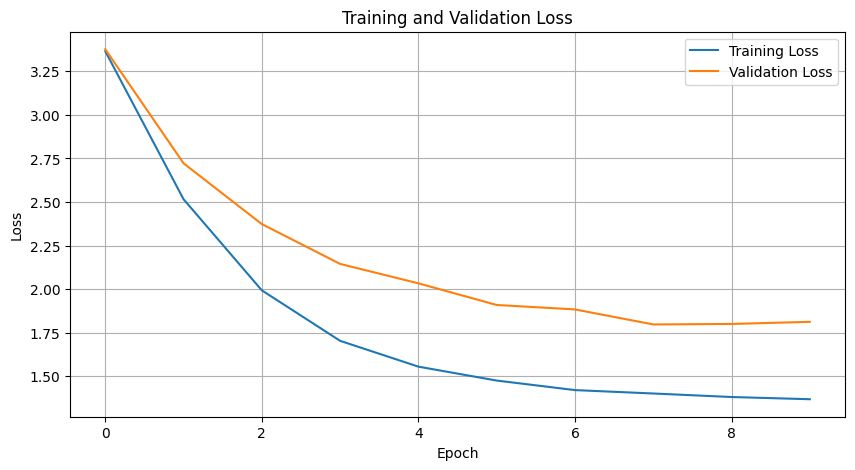

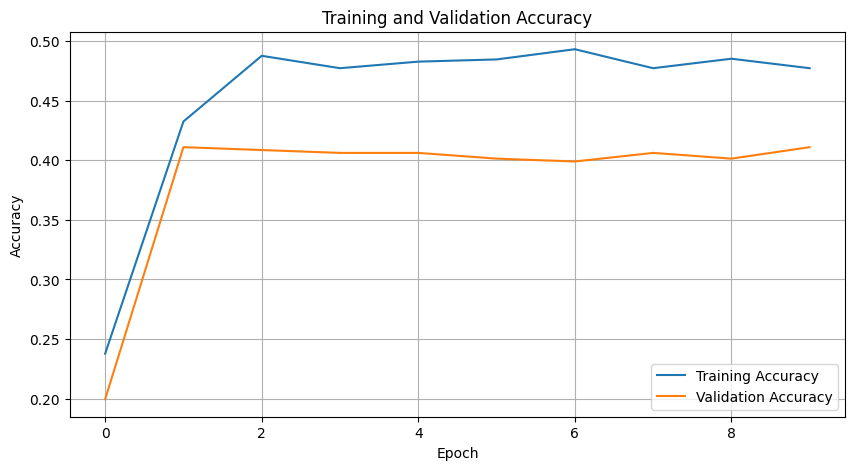

# Auxiliary Functions

In [ ]:
import gc

# Rerunning a cell (e.g. data loading) can sometimes cause mem to increase.
# This can clear some of the unused memory, without getting rid of everything.
gc.collect()
